# Step Detection using Ensemble Learning (SVM) on NURVV Trackers

In [42]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time
from scipy.optimize import curve_fit
import pylab
from sklearn import preprocessing
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import matplotlib
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score
from imblearn.metrics import geometric_mean_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
# The following variables will allow to set the figures in a way that they can be read in the article
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGISH_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

# Resets matplotlib style configuration. Uncomment this line if you want previous configurations being applied.
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [43]:
data_folder = 'Run Data/2017-12-12_Trials/Riv6b' # _Josh

df_acc = pd.read_csv(data_folder + '/imu_acc.csv') 
df_gyro = pd.read_csv(data_folder + '/imu_gyro.csv') 
df_gyro['Gyro-X'] = df_gyro['Gyro-X'].multiply(0.017453)
df_gyro['Gyro-Y'] = df_gyro['Gyro-Y'].multiply(0.017453)
df_gyro['Gyro-Z'] = df_gyro['Gyro-Z'].multiply(0.017453)
df_acc['Accel-X'] = df_acc['Accel-X'].multiply(9.80665)
df_acc['Accel-Y'] = df_acc['Accel-Y'].multiply(9.80665)
df_acc['Accel-Z'] = df_acc['Accel-Z'].multiply(9.80665)

data_imu = [(df_acc['TimeStamp'].values - df_acc['TimeStamp'].values[0])/1_000,
            df_acc['Accel-X'].values, 
            df_acc['Accel-Y'].values, 
            df_acc['Accel-Z'].values, 
            df_gyro['Gyro-X'].values, 
            df_gyro['Gyro-Y'].values, 
            df_gyro['Gyro-Z'].values]

df_imu = pd.DataFrame(data_imu)
df_imu = df_imu.T
df_imu.columns = ['Timestamp', 'Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']
df_imu = df_imu.set_index('Timestamp')

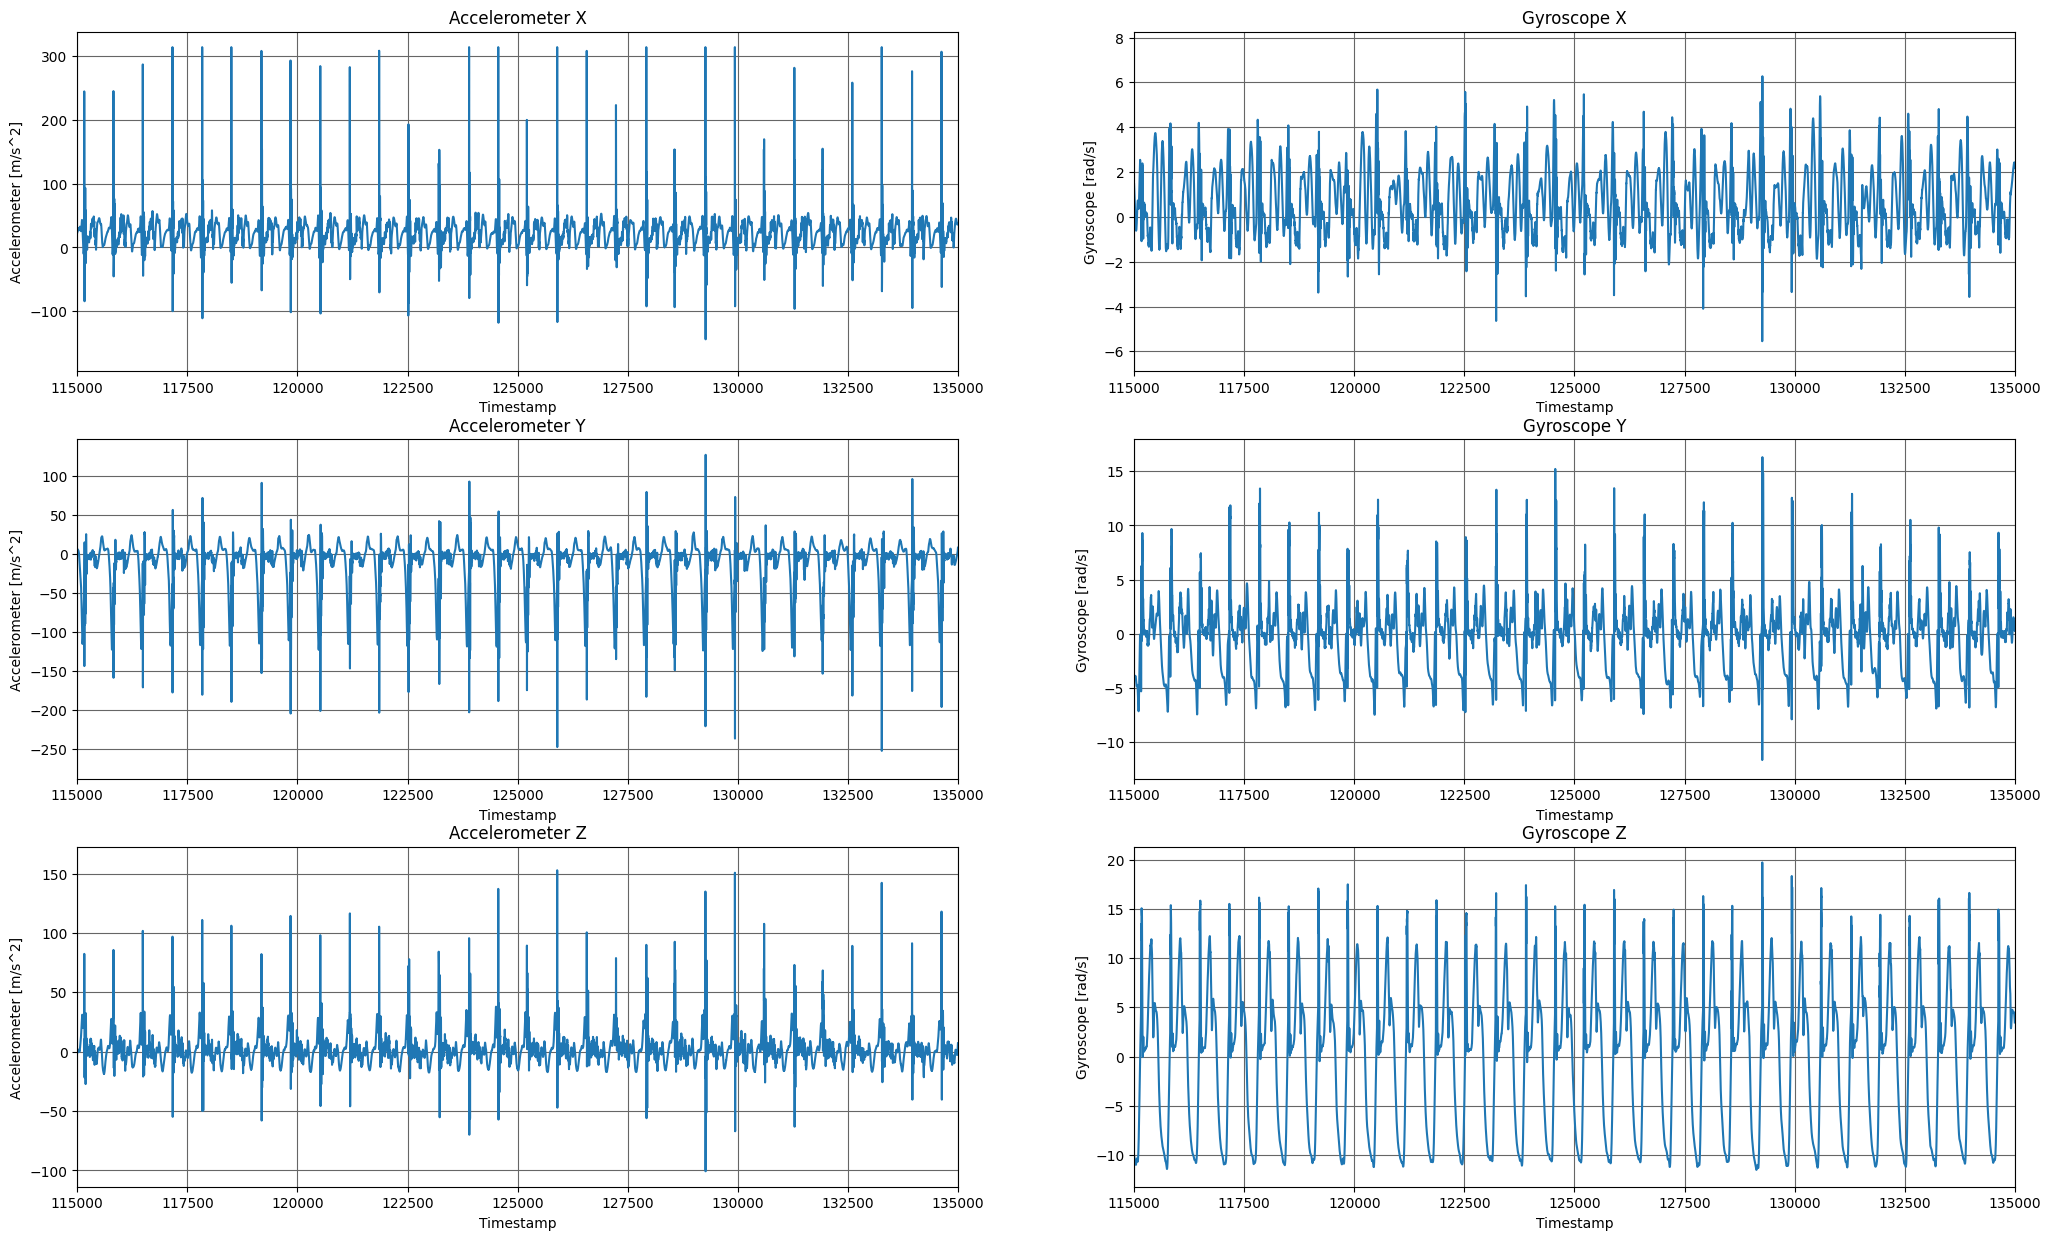

In [44]:
# Inspect IMU data at Footstrike
initial_timestamp_to_inspect = 115000
final_timestamp_to_inspect = 135000

plt.figure(figsize=(25,15))

plt.subplot(321)
plt.title(f"Accelerometer X")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-X'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(323)
plt.title(f"Accelerometer Y")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Y'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(325)
plt.title(f"Accelerometer Z")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Z'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(322)
plt.title(f"Gyroscope X")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-X'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(324)
plt.title(f"Gyroscope Y")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Y'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(326)
plt.title(f"Gyroscope Z")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Z'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.show()

In [45]:
# Crop IMU data to running period
initial_timestamp_to_crop = initial_timestamp_to_inspect
final_timestamp_to_crop = final_timestamp_to_inspect

df_imu = df_imu[(df_imu.index > initial_timestamp_to_crop) & (df_imu.index < final_timestamp_to_crop)]

df_imu_mag = df_imu[['Accel-X', 'Gyro-X']]
df_imu_mag = df_imu_mag.rename(columns={'Accel-X':'Accel', 'Gyro-X':'Gyro'})

accel_mag = list(np.sqrt(np.diff(df_imu['Accel-X'])**2+np.diff(df_imu['Accel-Y'])**2+np.diff(df_imu['Accel-Z'])**2))
accel_mag.insert(0, accel_mag[0])
df_imu_mag['Accel'] = accel_mag

gyro_mag = list(np.sqrt(np.diff(df_imu['Gyro-X'])**2+np.diff(df_imu['Gyro-Y'])**2+np.diff(df_imu['Gyro-Z'])**2))
gyro_mag.insert(0, gyro_mag[0])
df_imu_mag['Gyro'] = gyro_mag

std_scaler = preprocessing.StandardScaler()
df_mean_feats = pd.DataFrame(std_scaler.fit_transform(df_imu_mag[['Accel', 'Gyro']].values)).mean(axis=1)

N = 40
df_mean_feats_conv = np.convolve(df_mean_feats.values, np.ones(N)/N, mode='same')

threshold = 0.33

df_step = pd.Series(df_mean_feats_conv).to_frame()
df_step.index = df_imu_mag.index
df_step.columns = ['value']

df_imu_label = pd.DataFrame(1*(df_step.values > threshold), columns=['FSD'])
df_imu_label.index = df_imu.index

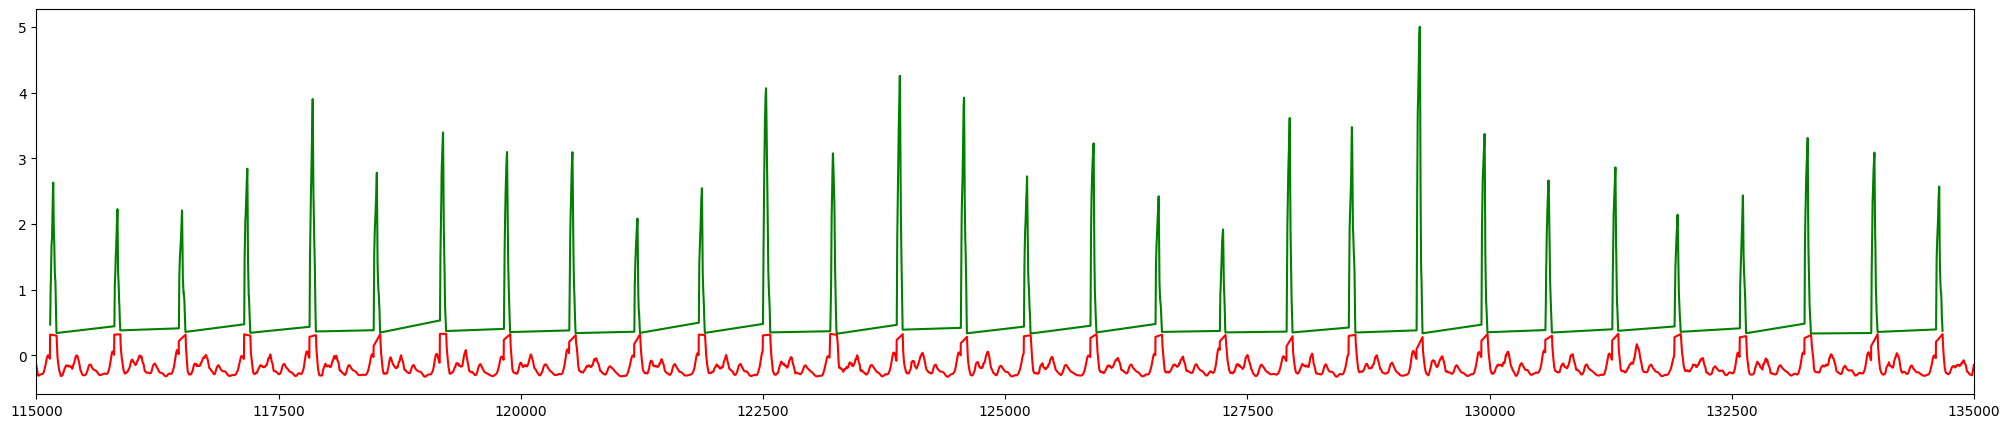

In [47]:
plt.figure(figsize=(25,5))
plt.plot(df_step[df_step['value']>threshold].index, df_step[df_step['value']>threshold], 'green')
plt.plot(df_step[df_step['value']<threshold].index, df_step[df_step['value']<threshold], 'red')
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
plt.show()

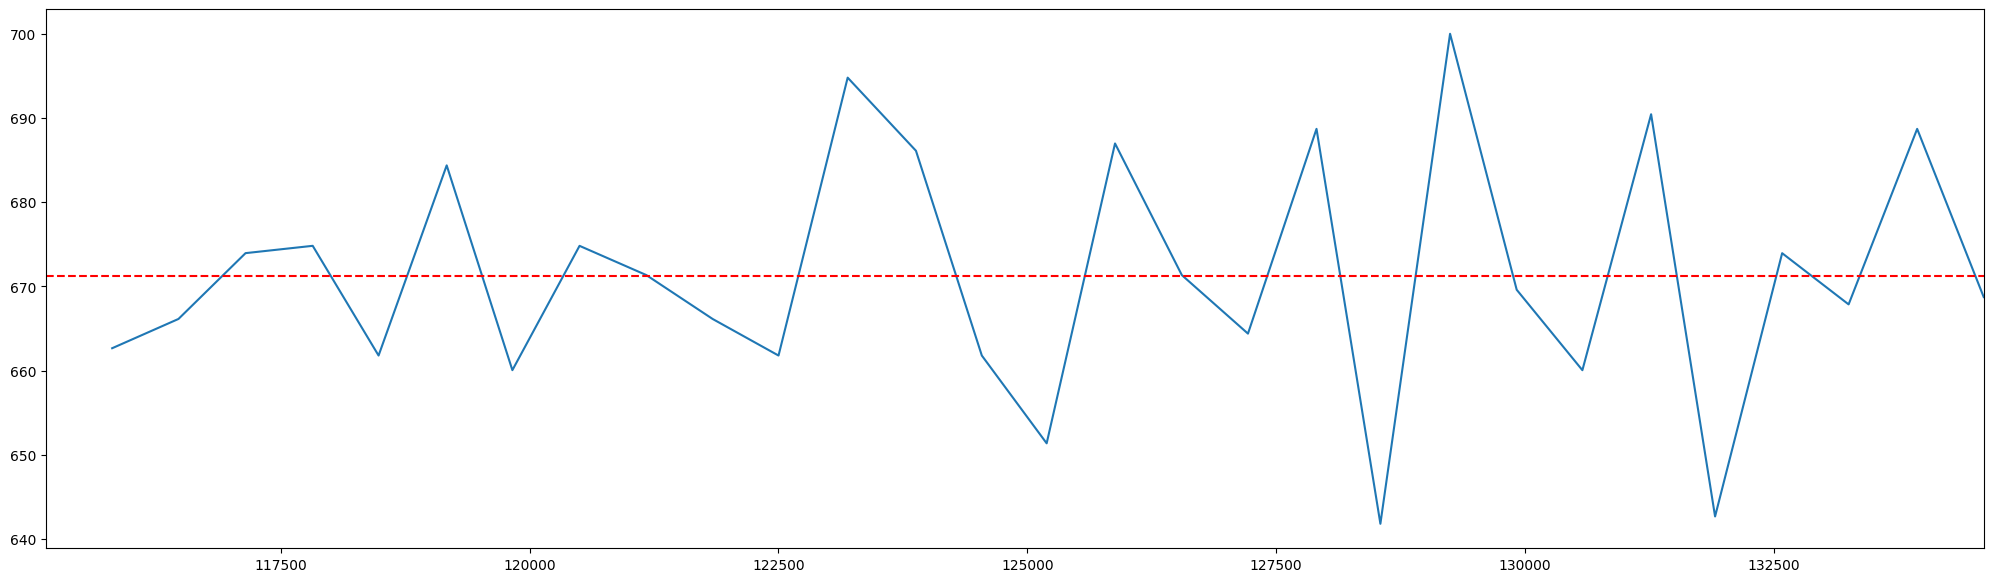

In [48]:
step_detected = list()
rest_detected = list()
is_step = df_step['value'] > threshold

past_val = is_step.values[0]
for i in range(len(is_step)-1):
    if not is_step.values[i] and is_step.values[i+1]:
        step_detected.append(is_step.index[i+1])
    
    if is_step.values[i] and not is_step.values[i+1]:
        rest_detected.append(is_step.index[i+1])
    
plt.figure(figsize=(25,7))
plt.plot(step_detected[1:], np.diff(step_detected))
plt.axhline(np.mean(np.diff(step_detected)), c='red', ls='--')
plt.xlim([step_detected[0], step_detected[-1]])
plt.show()

# If the samples are concentrated around the average line that's perfect
# If we have an outlier above, means we missed a label
# If we have an outlier below, means we overdetected a label

[[4079   76]
 [  56  395]]


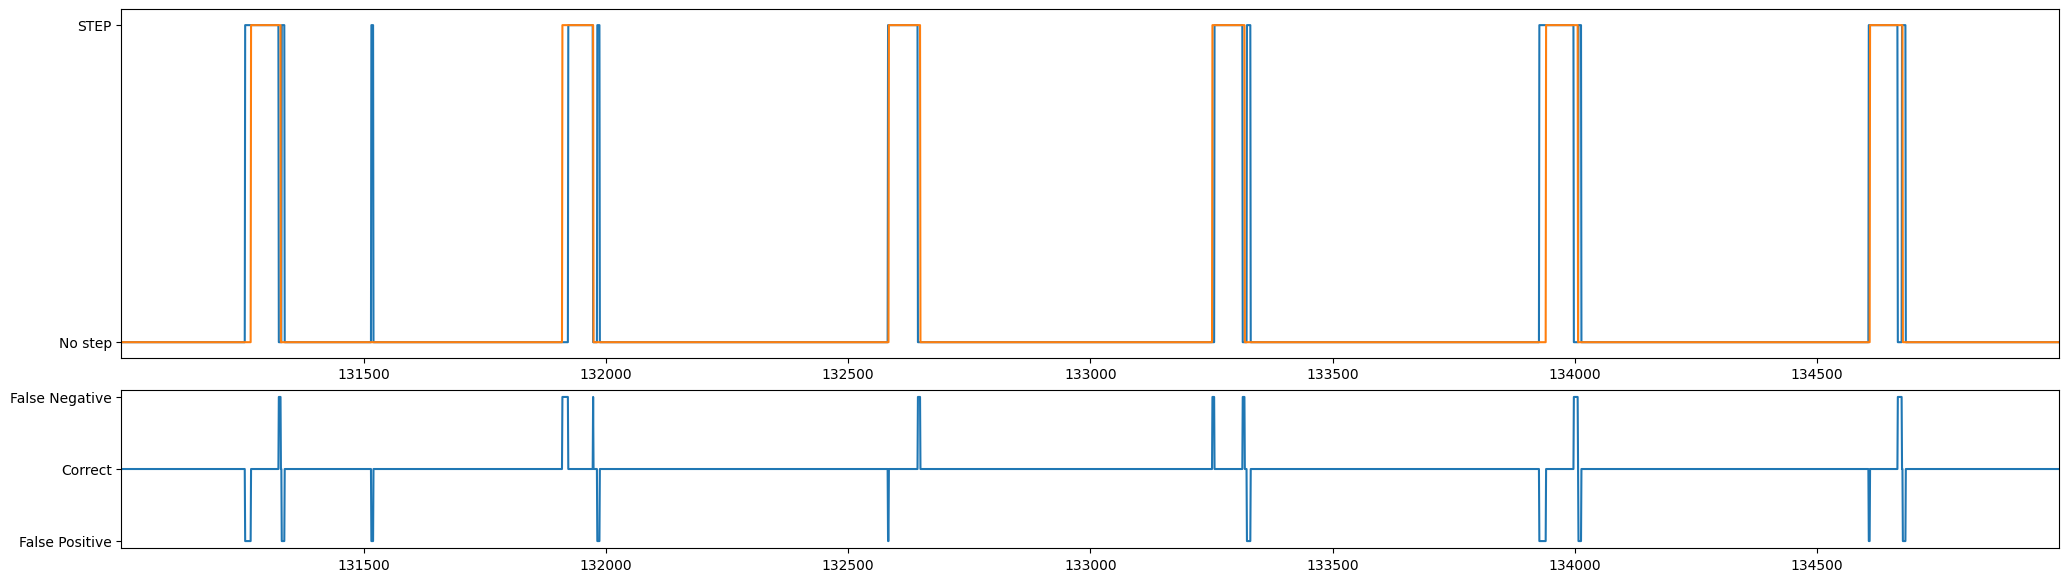

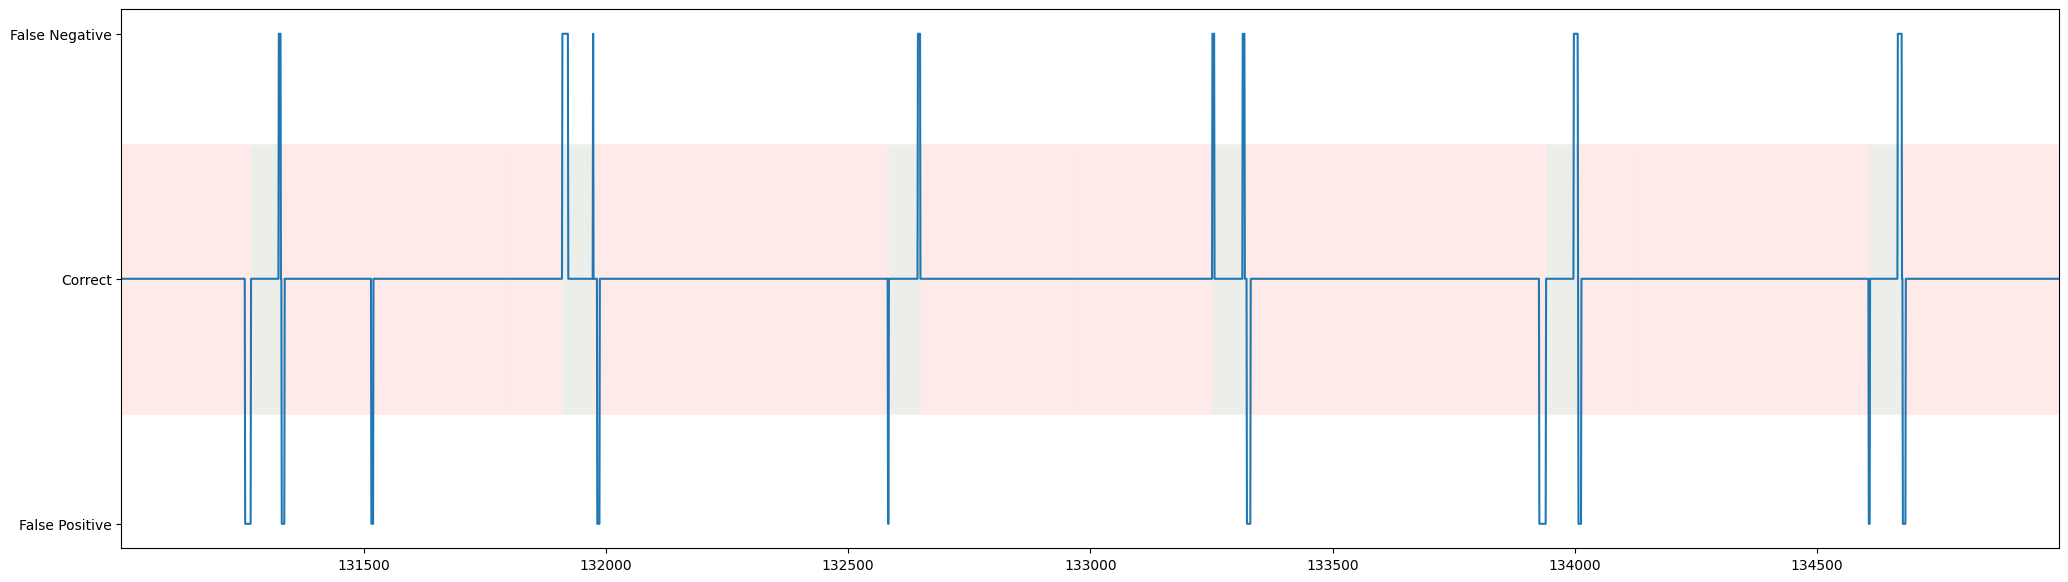

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    df_imu[['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']], 
    df_imu_label['FSD'], 
    test_size = 0.20,
    shuffle=False)

n_estimators = 10
clf = BaggingClassifier(SVC(kernel='rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# This rolling allows to remove spurious samples
# However, we can't use a lot of samples on the MA window otherwise we'll delay the rise edge of the recognition of a step
df_pred = pd.DataFrame(y_pred, columns=['FSD'])
df_pred['FSD'] = np.ceil(df_pred['FSD'].rolling(5, min_periods=1).mean())

cm = confusion_matrix(y_test.values, df_pred['FSD'].values)
print(cm)

initial_time_insepct = y_test.index[0]
final_time_insepct = y_test.index[-1]

plt.figure(figsize=(25,7))
plt.subplot(3,1,(1,2))
plt.plot(y_test.index, df_pred['FSD'].values)
plt.plot(y_test.index, y_test.values)
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([0, 1], ['No step', 'STEP'])

plt.subplot(3,1,3)
plt.plot(y_test.index, y_test.values-df_pred['FSD'].values)
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([-1, 0, 1], ['False Positive', 'Correct', 'False Negative'])
plt.show()

fig, ax = plt.subplots(figsize=(25,7))
colors = ['red', 'green']

plt.plot(y_test.index, y_test.values-df_pred['FSD'].values)
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([-1, 0, 1], ['False Positive', 'Correct', 'False Negative'])
for idx, lbl in enumerate(y_test.values):
    ax.axvspan(y_test.index[idx-1], y_test.index[idx], ymin=.25, ymax=.75, alpha=0.01, color=colors[int(lbl)])

plt.show()

# ENSEMBLE MODEL

In [14]:
# In practice we should load a different dataset to test on!

In [51]:
models = list()
models.append(pickle.load(open('josh_model.sav', 'rb')))
models.append(pickle.load(open('grant_model.sav', 'rb')))
models.append(pickle.load(open('FenMichael.sav', 'rb')))
models.append(pickle.load(open('ITLcombo.sav', 'rb')))
models.append(pickle.load(open('riv6a.sav', 'rb')))

In [55]:
predictions = list()
probabilities = list()
X_test = df_imu[['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']]
y_test = df_imu_label['FSD']

for model in models:
    print("Processing model ...")
    probabilities.append(np.max(model.predict_proba(X_test), axis=1))
    predictions.append(model.predict(X_test))

Processing model ...
Processing model ...
Processing model ...
Processing model ...
Processing model ...


In [56]:
df_probs = pd.DataFrame(probabilities).T
df_probs['idxmax'] = df_probs.idxmax(axis = 1)
df_probs.head()

,0,1,2,3,4,idxmax
0,0.999933,0.984134,0.999909,0.999976,1.0,4
1,0.999933,0.983994,0.999895,0.999974,1.0,4
2,0.999935,0.984260,0.999879,0.999971,1.0,4
3,0.999934,0.984736,0.999867,0.999968,1.0,4
4,0.999932,0.984888,0.999856,0.999963,1.0,4


In [57]:
df_preds = pd.DataFrame(predictions).T
df_preds.head()

,0,1,2,3,4
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [58]:
df_test = df_preds.copy()
df_test['idxmax'] = df_probs['idxmax']
df_test = df_test.drop(columns=range(len(models)))

df_test.head()

,idxmax
0,4
1,4
2,4
3,4
4,4


In [59]:
df_ensemble = pd.DataFrame(pd.concat([df_test['idxmax'], df_preds], ignore_index=True, axis=1))
df_ensemble = df_ensemble.rename(columns = {0:'idxmax'})
df_ensemble.head()

,idxmax,1,2,3,4,5
0,4,0,0,0,0,0
1,4,0,0,0,0,0
2,4,0,0,0,0,0
3,4,0,0,0,0,0
4,4,0,0,0,0,0


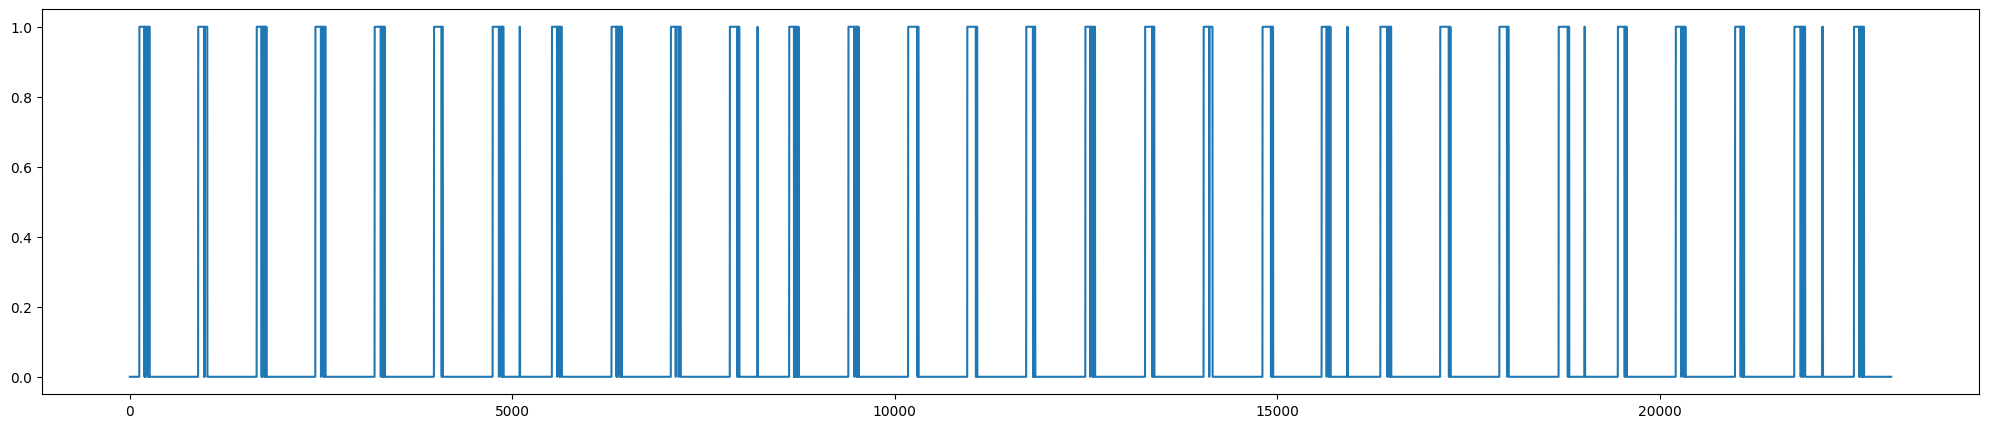

In [61]:
hard_voting = df_ensemble.apply(lambda x: x[x['idxmax']+1], axis=1).values
plt.figure(figsize=(25,5))
plt.plot(hard_voting)
plt.show()

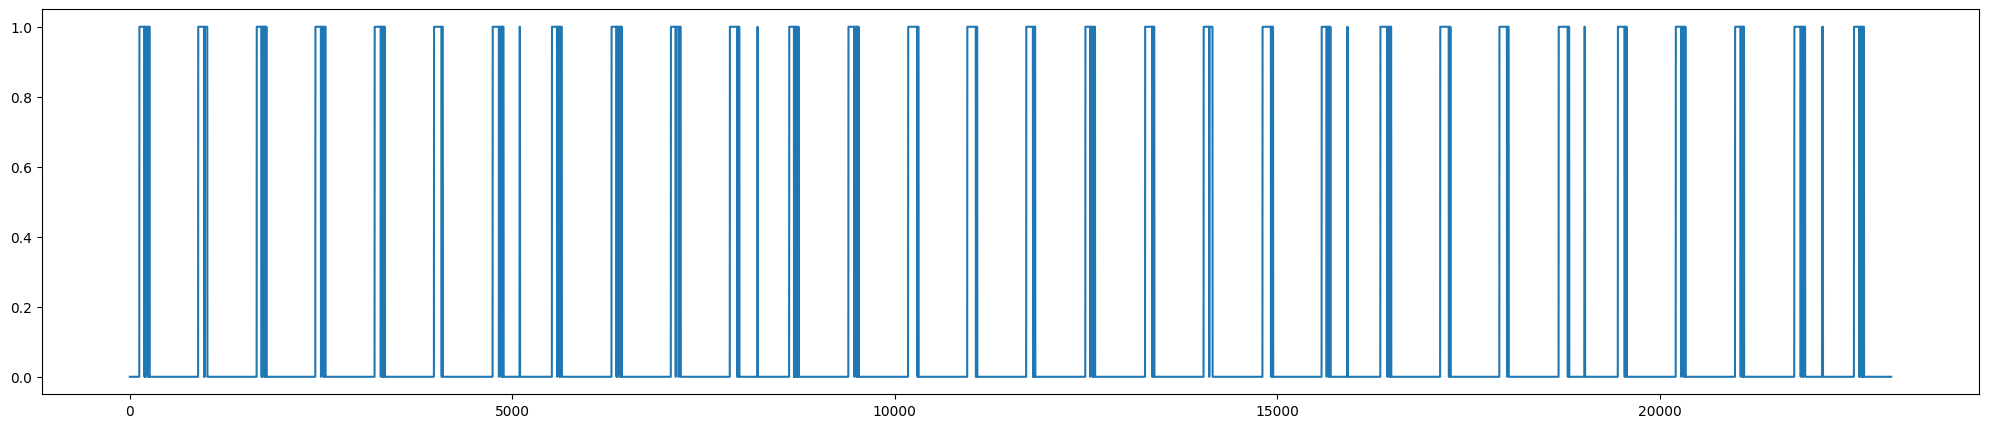

In [62]:
pred_ensemble = np.floor(pd.DataFrame(hard_voting).rolling(7, min_periods=1).mean())
plt.figure(figsize=(25,5))
plt.plot(hard_voting)
plt.show()

In [63]:
cm = confusion_matrix(y_test.values, pred_ensemble)
print(cm)

[[19624  1160]
 [  422  1823]]


In [64]:
f1_score(y_test.values, pred_ensemble)

0.6973986228003062

In [65]:
geometric_mean_score(y_test.values, pred_ensemble)

0.8756173581527497

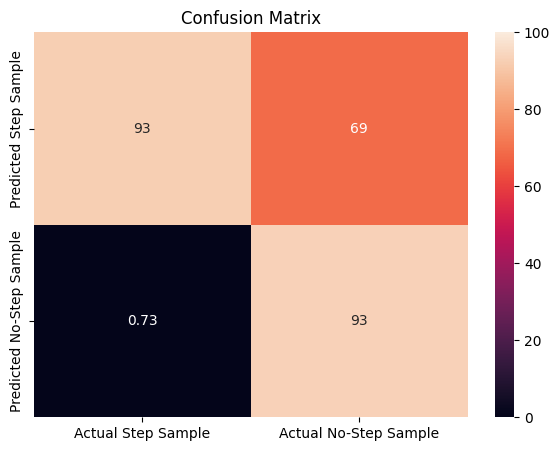

In [66]:
C = confusion_matrix(y_test.values, hard_voting)

df_cm = pd.DataFrame(100*C / C.astype(np.float).sum(axis=1), 
                     index = ['Predicted Step Sample', 'Predicted No-Step Sample'],
                     columns = ['Actual Step Sample', 'Actual No-Step Sample'])
plt.figure(figsize = (7,5))
plt.title('Confusion Matrix')
sns.heatmap(df_cm, vmin=0, vmax=100, annot=True)
plt.show()

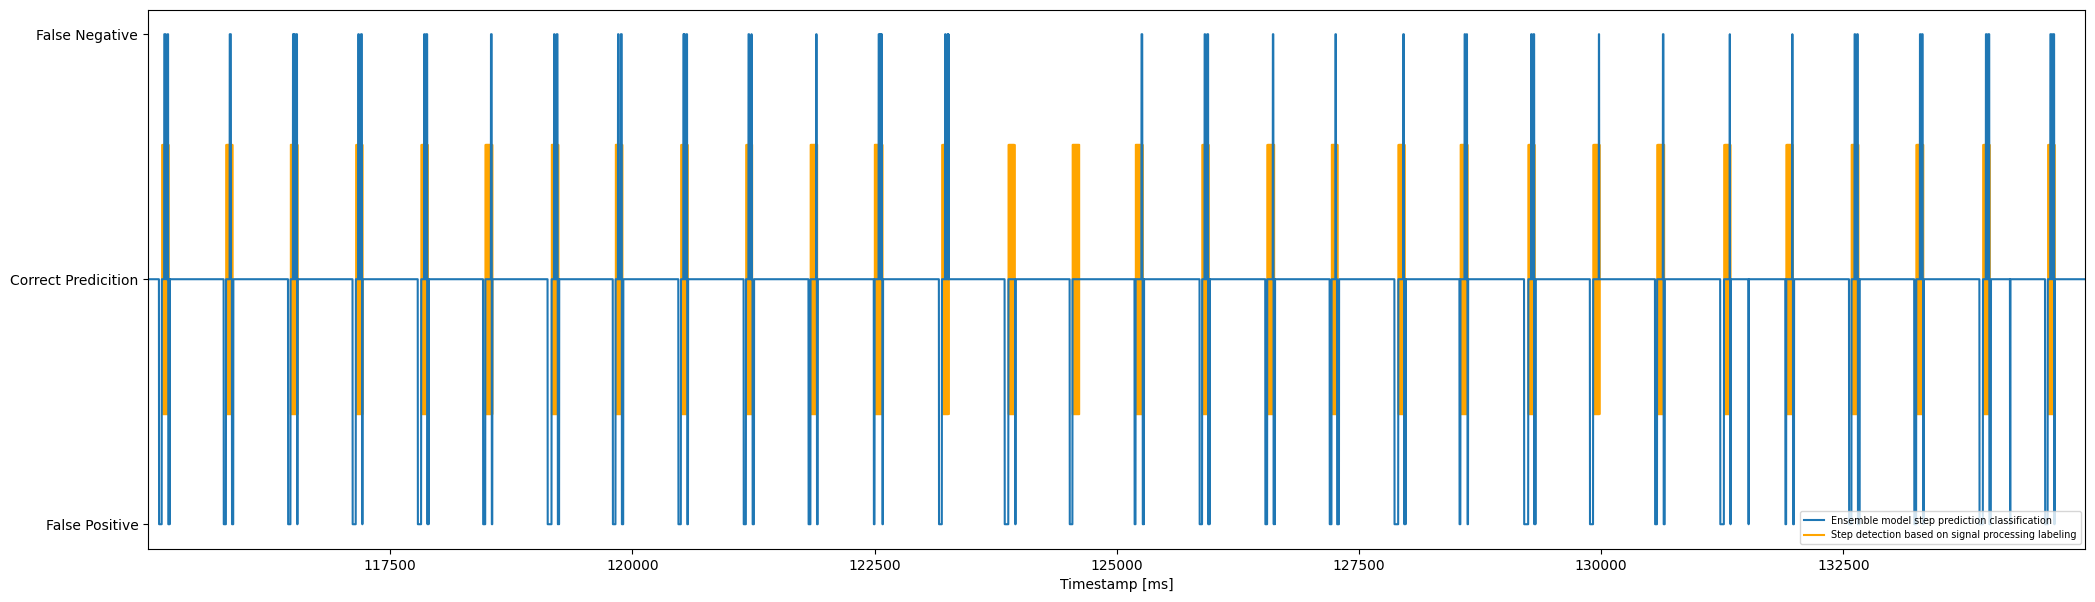

In [68]:
initial_time_insepct = y_test.index[0]
final_time_insepct = y_test.index[-1]

fig, ax = plt.subplots(figsize=(25,7))
colors = ['red', 'green']
#plt.title('Ensemble Classification output on unseen data set')
plt.plot(y_test.index, y_test.values-pred_ensemble[0].values)
plt.plot([-1, -1], [-1, -1], color='orange')
plt.legend(["Ensemble model step prediction classification", "Step detection based on signal processing labeling"], loc=4, fontsize='x-small')
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([-1, 0, 1], ['False Positive', 'Correct Predicition', 'False Negative'])
for idx, lbl in enumerate(y_test.values):
    if int(lbl):
        ax.axvspan(y_test.index[idx-1], y_test.index[idx], ymin=.25, ymax=.75, color='orange')
plt.xlabel('Timestamp [ms]')
plt.show()